---
# Customer Loan Eligibility Prediction
---

### Data Science Project - UOM
#### 239306V Banujan C

## Context: 
---

One of the best finance companies in Sri Lanka offers home loans and have a presence in urban, semi-urban, and rural areas. When a customer wants to apply for a home loan, the finance company checks if they are eligible. To automate this process, company has given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here we are using a sample dataset which is similar to the finance company dataset.
 

## Data Dictionary:
--------------------------

The data contains the following attributes:

* **Loan_ID**: Unique Loan ID
* **Gender**: Gender of the applicant - Male/Female
* **Married**: Whether the applicant is married or not (Yes/No)
* **Dependents**: Number of dependents of the applicant
* **Education**: Applicant's education (Graduate/Not Graduate)
* **Self_Employed**: Whether the applicant is self-employed (Yes/No)
* **ApplicantIncome**: The income of the applicant (\$)
* **CoapplicantIncome**: The co-applicant's income in case of a joint loan and 0 otherwise (\$)
* **LoanAmount**: Loan amount (dollars in thousands) 
* **Loan_Amount_Term**: Term of loan in months
* **Credit_History**: Whether the applicant's credit history meets required guidelines
* **Property_Area**: The area the property pertaining to the loan belongs to - Urban/Semi-Urban/Rural
* **Loan_Status**: Loan approved (1 - Yes, 0 - No)

## Importing necessary libraries and overview of the dataset

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#To scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

import warnings
warnings.filterwarnings("ignore")

**Loading Data**

In [13]:
data = pd.read_csv("/Users/banujan-macbookpro/Downloads/customer_loan.csv")
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


#### Dataset Information

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [15]:
data.Loan_ID.nunique()

614

## Exploratory Data Analysis and Data Preprocessing

**Dropping Loan_ID column**

In [16]:
data.drop(columns=['Loan_ID'], inplace = True)

**Summary Statistics for numerical columns**

In [17]:
#Creating a list of numerical columns
num_cols = num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

#printing summary statistics

data[num_cols].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,592.000000,600.00000
mean,5403.459283,1621.245798,146.412162,342.00000
std,6109.041673,2926.248369,85.587325,65.12041
min,150.000000,0.000000,9.000000,12.00000
25%,2877.500000,0.000000,100.000000,360.00000
50%,3812.500000,1188.500000,128.000000,360.00000
75%,5795.000000,2297.250000,168.000000,360.00000
max,81000.000000,41667.000000,700.000000,480.00000


## Feature Engineering

In [18]:
#Converting the scale of loan term from months to years
data['Loan_Amount_Term']=data['Loan_Amount_Term']/12

In [19]:
#Adding the applicant and co-applicant income to get the total income per application
data['total_income']=data['ApplicantIncome'] + data['CoapplicantIncome']

In [20]:
#Dropping the columns as we created a new column which captures the same information
data.drop(columns=['ApplicantIncome', 'CoapplicantIncome'], inplace=True)

**Checking the distribution and outliers for each column in the data**

LoanAmount
Skew : 2.68


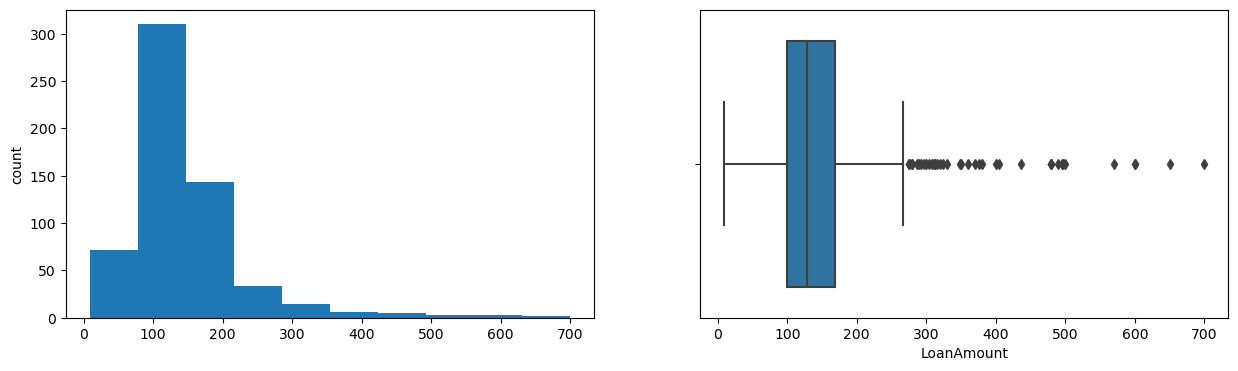

total_income
Skew : 5.63


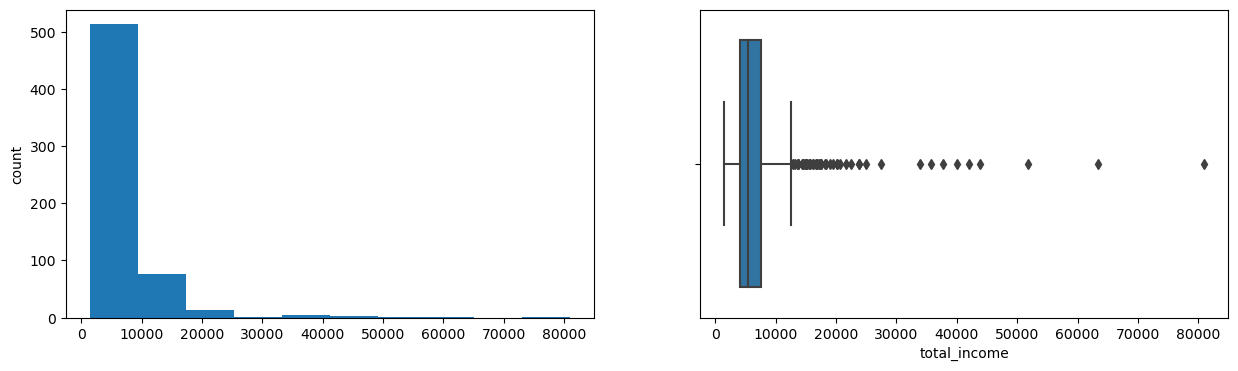

In [21]:
for col in ['LoanAmount', 'total_income']:
    print(col)
    print('Skew :',round(data[col].skew(),2))
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    data[col].hist(bins=10, grid=False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=data[col])
    plt.show()


- Both the variables are highly skewed to the right and have many outliers which can be expected as the data contains different types of areas - Rural, Urban & Semi-Urban. 
- We can observe from the histogram that majority of values for total income are less than 10,000

Now, let's check the percentage of observations in each category for all the categorical variables.

### Checking percentage of each category for categorical variables

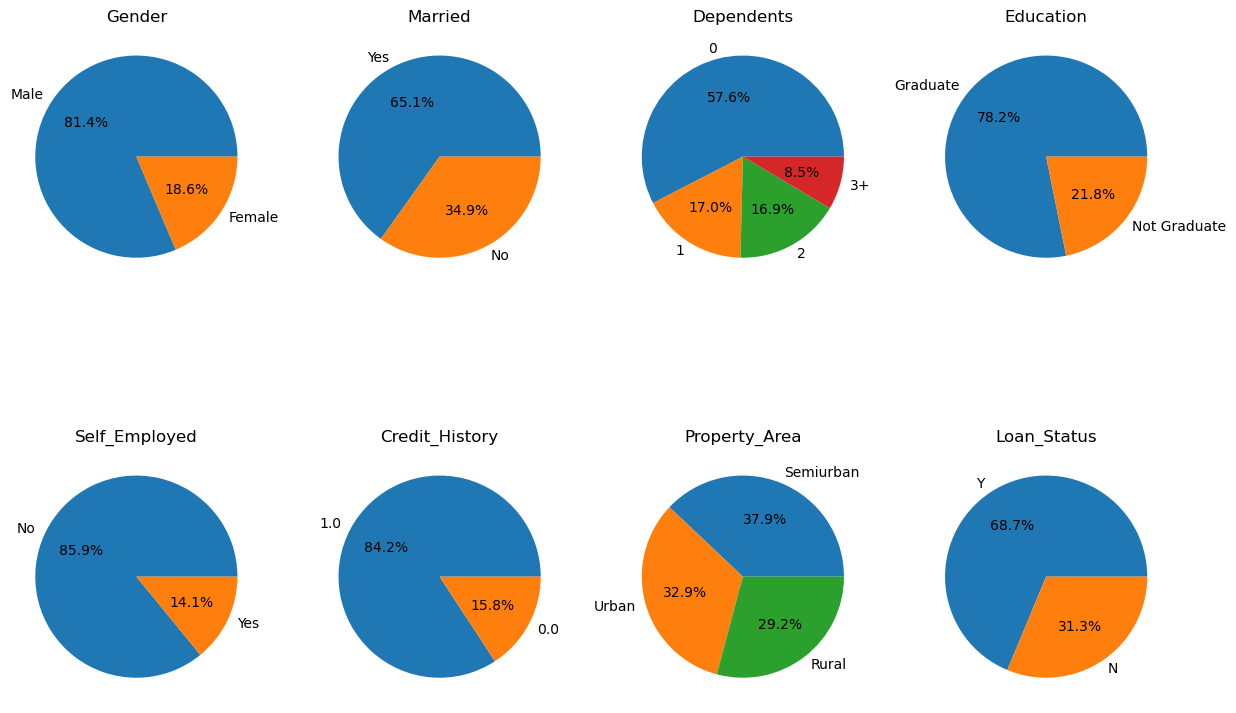

****************************************


In [22]:
cat_col = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']
num_plots = len(cat_col)
num_rows = num_plots // 4 + (num_plots % 4 > 0)
fig, axs = plt.subplots(num_rows, 4, figsize=(15, 5*num_rows))

for i, col in enumerate(cat_col):
    row_idx = i // 4
    col_idx = i % 4
    values = data[col].value_counts(normalize=True)
    axs[row_idx, col_idx].pie(values, labels=values.index, autopct='%1.1f%%')
    axs[row_idx, col_idx].set_title(col)

plt.show()
print('*' * 40)

In [23]:
#Creating list of categorical columns
cat_col= ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History','Property_Area', 'Loan_Status']

for col in cat_col:
    print(data[col].value_counts(normalize=True)) #Write your code here
    print('*'*40)                #Print the * 40 times to separate different variables

Male      0.813644
Female    0.186356
Name: Gender, dtype: float64
****************************************
Yes    0.651391
No     0.348609
Name: Married, dtype: float64
****************************************
0     0.575960
1     0.170284
2     0.168614
3+    0.085142
Name: Dependents, dtype: float64
****************************************
Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64
****************************************
No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64
****************************************
1.0    0.842199
0.0    0.157801
Name: Credit_History, dtype: float64
****************************************
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64
****************************************
Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64
****************************************



* The vast majority of applicants are male (81%). 

* 65% of applicants are married, and 57% of them have no dependents

* 78% of the applicants are graduates

* 85% of the applicants are self employed

* 84% of the applicants have credit histories that meet the required guidelines

* The property area among the applicants is roughly evenly split across semiurban, urban, and rural, with semi-urban having a slightly higher portion (37.9%)

## Imputing missing values

In [24]:
#Imputing missing values with mode for the categorical variables 
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']:
    data[col].fillna(value=data[col].mode()[0], inplace=True)

In [25]:
#Replacing 0's with null values in loan amount 
data.LoanAmount.replace(0, np.nan, inplace=True)

#Imputing null values in loan amount with the median
data.LoanAmount.fillna(value=data.LoanAmount.median(), inplace=True)

**Checking for null values**

In [26]:
data.isnull().sum()

Gender              0
Married             0
Dependents          0
Education           0
Self_Employed       0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
Property_Area       0
Loan_Status         0
total_income        0
dtype: int64

**Finally, we need to encode our loan status column to make it eligible for modeling**

In [27]:
data.replace({"Loan_Status":{'N':0,'Y':1}},inplace=True) # label encoding

**We are now done with data preprocessing**

## Bivariate Analysis

In [28]:
#data["Loan_Status"].size
data["Loan_Status"].count()

614

In [29]:
data["Loan_Status"].value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

In [30]:
data["Loan_Status"].value_counts(normalize=True)*100

1    68.729642
0    31.270358
Name: Loan_Status, dtype: float64

<AxesSubplot:title={'center':'Loan_Status'}>

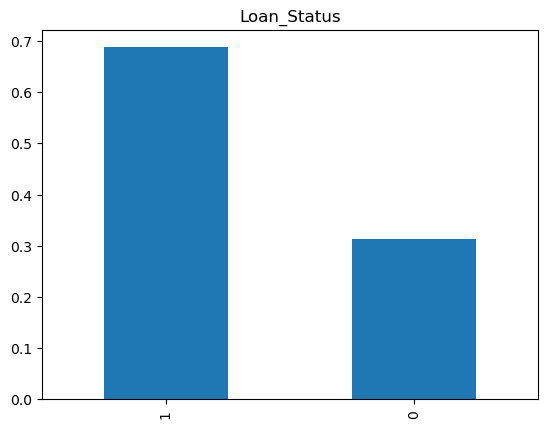

In [31]:
data["Loan_Status"].value_counts(normalize=True).plot.bar(title = 'Loan_Status')

In [32]:
data['Gender'].value_counts(normalize=True)*100

Male      81.758958
Female    18.241042
Name: Gender, dtype: float64

<AxesSubplot:title={'center':'Gender'}>

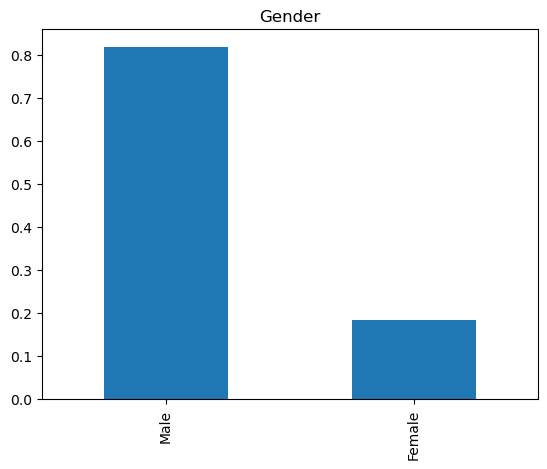

In [33]:
data['Gender'].value_counts(normalize=True).plot.bar(title= 'Gender')

Let's check the relationship of loan amount with the total income

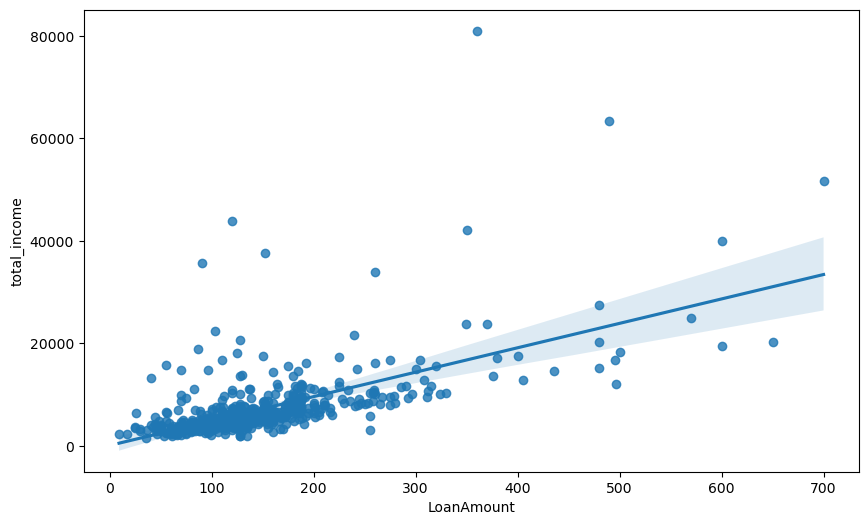

In [34]:
plt.figure(figsize=(10,6))
sns.regplot(x='LoanAmount', y='total_income', data=data)
plt.show()

- The plot shows that the loan amount is positively correlated with total income. This implies that the loan amount for higher-income applicants is progressively higher.
- There are some outliers visible, showing applicants with low income having been given loans of a higher amount.

Let's check the relatioship of total income with loan status

<AxesSubplot:xlabel='Loan_Status', ylabel='total_income'>

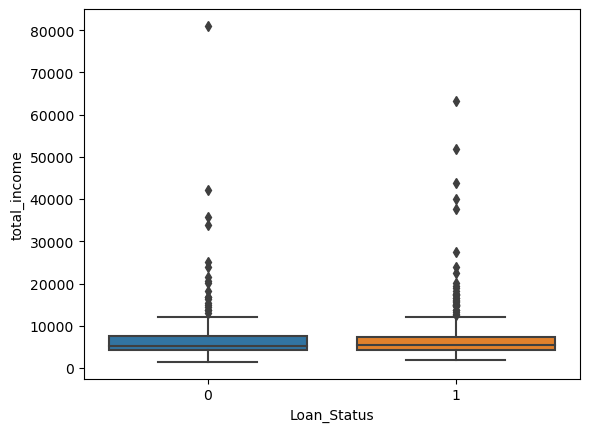

In [35]:
sns.boxplot(x=data.Loan_Status, y=data.total_income)

- Except for some outliers, there is no major difference between the income of those customers who are eligible versus those who are not. 
- This implies that income alone might not be a good indicator of a customer's loan eligibility.

Let's check how credit history is related to loan status

<AxesSubplot:xlabel='Credit_History', ylabel='count'>

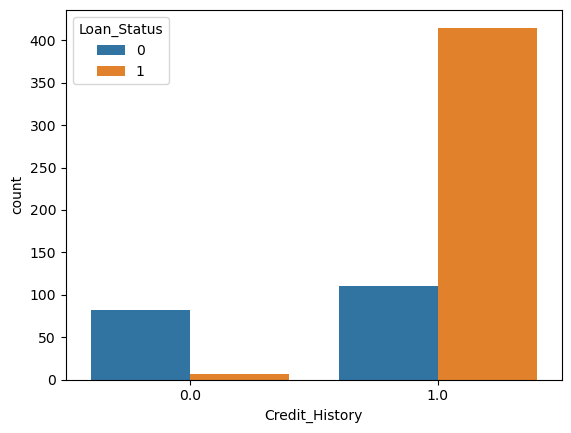

In [36]:
sns.countplot(x=data.Credit_History, hue=data.Loan_Status)

- The plot shows that credit history is an important factor while checking loan eligibility. There are very few customers whose loan was approved even when their credit history did not meet required guidelines.

Let's check the relationship between education and loan status

<AxesSubplot:xlabel='Education', ylabel='count'>

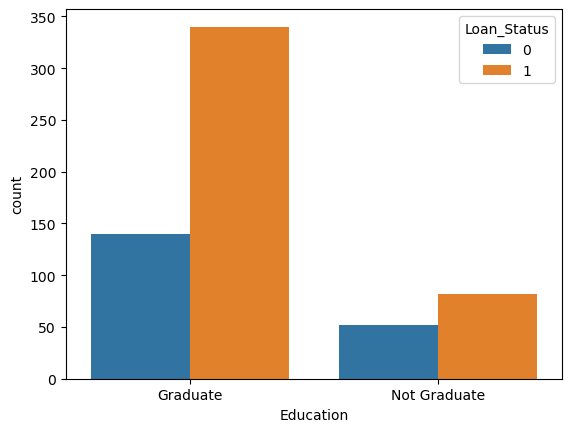

In [37]:
sns.countplot(x=data.Education, hue=data.Loan_Status)

Here graduate customers are more likely to get loans.


Let's check if property area is related with loan status

<AxesSubplot:xlabel='Property_Area', ylabel='count'>

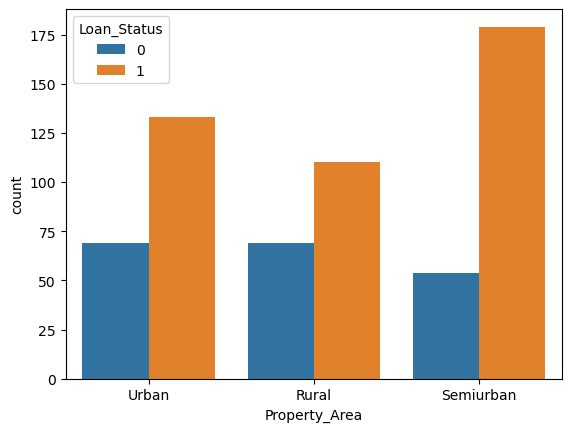

In [38]:
sns.countplot(x=data.Property_Area, hue=data.Loan_Status)

- The plot shows that more loans are approved for properties in semi-urban areas. 
- This could be due to several reasons. The bank might be charging higher interest rates for semi-urban areas or the current customer base of the company from semi-urban areas might actually be more eligible for home loans based on loan applicant features. We cannot be certain as we don't have the data to support this claim.

**Now that we have processed and explored our data, let's prepare it for modeling.**

## Preparing data for modeling

- Models cannot take non-numeric inputs. So, we will first create dummy variables for all the categorical variables.
- We will then split the data into train and test sets.

In [39]:
#Separating target variable and other variables

X= data.drop(columns = ['Loan_Status'])
Y= data.Loan_Status

In [40]:
#Creating dummy variables 
#drop_first=True is used to avoid redundant variables
X = pd.get_dummies(X, drop_first=True)

In [41]:
#Splitting the data into train and test sets
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=1)

## Building Classification Models

**Before training the model, let's choose the appropriate model evaluation criterion as per the problem on hand.**

Also, let's create a function to calculate and print the classification report and confusion matrix so that we don't have to rewrite the same code repeatedly for each model.

In [42]:
#function to print classification report and get confusion matrix in a proper format

def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Eligible', 'Eligible'], yticklabels=['Not Eligible', 'Eligible'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Logistic Regression

In [43]:
#define logistic regression model 
log_reg= LogisticRegression(random_state = 1)

#fit the model
log_reg.fit(X_train,y_train)

LogisticRegression(random_state=1)

In [44]:
from sklearn import metrics
lr_prediction = log_reg.predict(X_test)
print('Logistic Regression accuracy = ', metrics.accuracy_score(lr_prediction,y_test))

Logistic Regression accuracy =  0.7891891891891892


**Let's check the coefficient of each dependent variable in the data**

In [45]:
pd.Series(log_reg.coef_[0], index=X_train.columns).sort_values(ascending=False)

Credit_History             3.026290
Property_Area_Semiurban    0.821607
Married_Yes                0.189415
Dependents_2               0.154743
Dependents_3+              0.113782
total_income              -0.000010
LoanAmount                -0.000475
Property_Area_Urban       -0.006443
Loan_Amount_Term          -0.065875
Self_Employed_Yes         -0.098512
Gender_Male               -0.106000
Dependents_1              -0.145728
Education_Not Graduate    -0.491757
dtype: float64

**Let's now find the odds calculated from the logistic regression model coefficients**

In [46]:
odds = np.exp(log_reg.coef_[0]) #finding the odds

#adding the odds to a dataframe and sorting the values
pd.DataFrame(odds, X_train.columns, columns=['odds']).sort_values(by='odds', ascending=False) 

,odds
Credit_History,20.620598
Property_Area_Semiurban,2.274152
Married_Yes,1.208542
Dependents_2,1.167358
Dependents_3+,1.120508
total_income,0.999990
LoanAmount,0.999526
Property_Area_Urban,0.993578
Loan_Amount_Term,0.936248
Self_Employed_Yes,0.906185


* The odds of an applicant's loan application being approved is around 20 times higher for a person who meets the loan approval requirements compared to someone who doesn't

* The odds of an applicant's loan application being approved is over double if he is married compared to someone who is not.

**Now, let's check the performance of the model on the training set**

              precision    recall  f1-score   support

           0       0.91      0.44      0.59       131
           1       0.80      0.98      0.88       298

    accuracy                           0.82       429
   macro avg       0.85      0.71      0.74       429
weighted avg       0.83      0.82      0.79       429



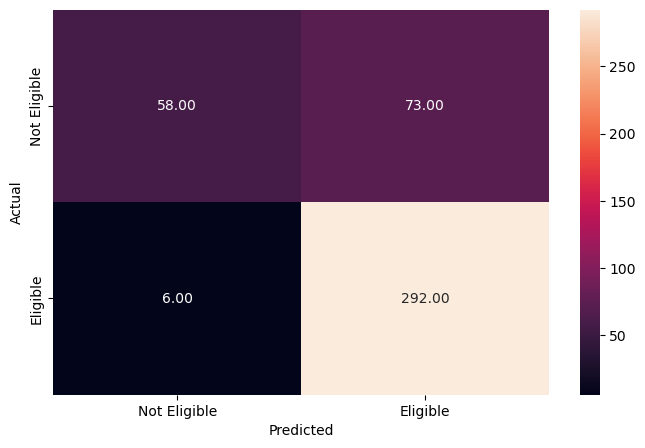

In [47]:
#predict on the training data 
y_pred_train = log_reg.predict(X_train) #Write your code here

# Checking performance on the training data
metrics_score(y_train, y_pred_train)

* We see around 82% accuracy on our training set.

* The recall score is only 44% for class 0 which is low, considering we want to get a strong recall value for our specific problem. Thus, this model will not perform well for us. 

**Precision-Recall curve for Logistic Regression**

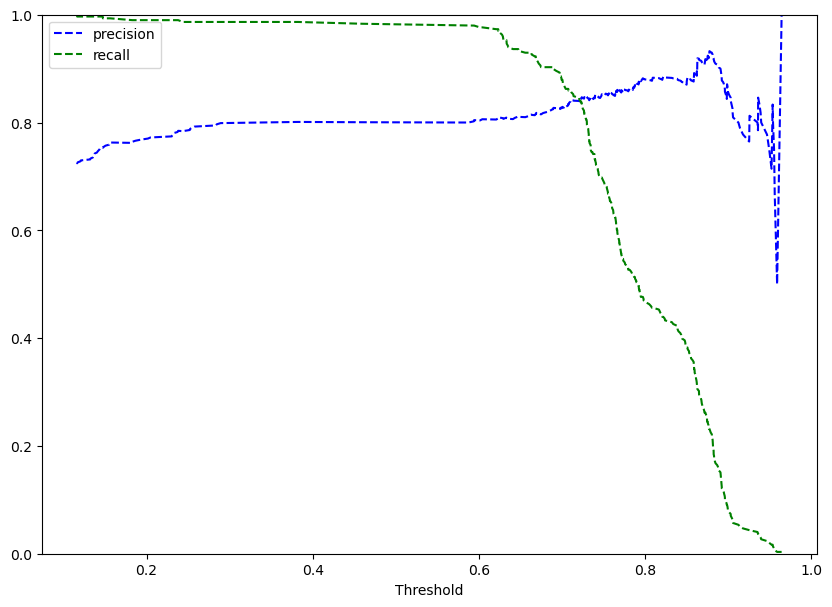

In [48]:
y_scores=log_reg.predict_proba(X_train) #predict_proba gives the probability of each observation belonging to each class


precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:,1])

#Plotting values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

- We can see that precision and recall are balanced for threshold of about 0.7.
- Let's try to calculate the exact threshold where precision and recall are equal.

In [49]:
#calculating the exact threshold where precision and recall are equal.
for i in np.arange(len(thresholds)):
    if precisions[i]==recalls[i]:
        print(thresholds[i])

0.7222070700676464


- The threshold of 0.72 would give a balanced precision and recall.
- We can choose the threshold to be a bit higher to make the recall higher but then the precision would drop.
- **This decision depends on the stakeholders and other business driven factors.** For example, if the company can bear the cost of some false positives and be more conservative while approving loans then we can choose for the recall to be higher.
- Let's choose the recall to be 0.75 for the current scenario, since we have mentioned that the company wants to optimize recall. 

**So let's compare the performance of the model on the training and testing sets after changing the threshold**

              precision    recall  f1-score   support

           0       0.51      0.73      0.60       131
           1       0.85      0.69      0.76       298

    accuracy                           0.70       429
   macro avg       0.68      0.71      0.68       429
weighted avg       0.75      0.70      0.71       429



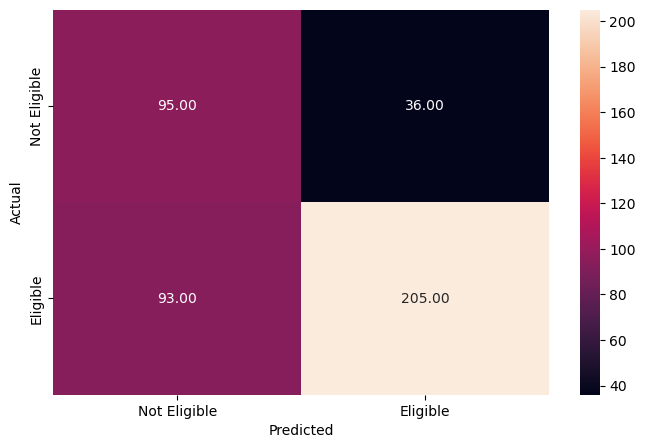

In [50]:
optimal_threshold1 = 0.75
metrics_score(y_train, y_scores[:,1]>optimal_threshold1)

              precision    recall  f1-score   support

           0       0.56      0.66      0.60        61
           1       0.81      0.74      0.78       124

    accuracy                           0.71       185
   macro avg       0.68      0.70      0.69       185
weighted avg       0.73      0.71      0.72       185



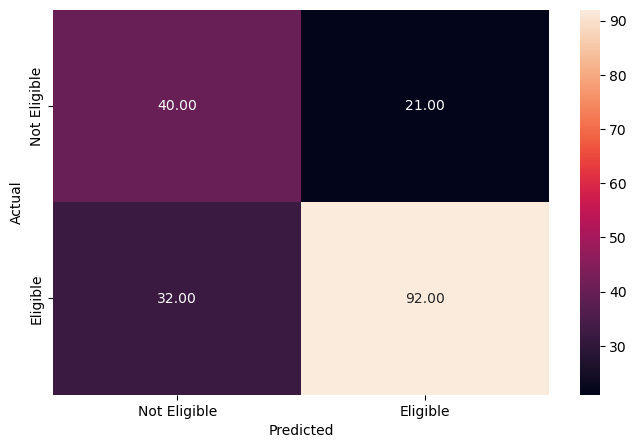

In [51]:
#Checking performance on the testing data
y_pred_test = log_reg.predict_proba(X_test)
metrics_score(y_test, y_pred_test[:,1]>optimal_threshold1)

* We can see that even though the precision dropped for class 0, the recall score is much higher after using the optimal threshold, and now our model is a lot more appropriate after improvement. 

* Similar performance on both the training data and the test data

### K - Nearest Neighbors (KNN)

- KNN is a distance based algorithm and all distance based algorithms are affected by the scale of the data.
- We will scale the attributes (dataframe X defined above) before building the KNN model.

**But before actually building the model, we need to identify the value of K to be used in KNN.

In [52]:
knn = KNeighborsClassifier()
ss = StandardScaler()

# We select the best value of k for which the error rate is the least in the validation data
# Let us loop over a few values of the k to determine the best k

train_error = []
test_error = []
knn_many_split = {}

error_df_knn = pd.DataFrame()
features = X.columns

for k in range(1,21):
    train_error = []
    test_error = []
    lista = []
    knn = KNeighborsClassifier(n_neighbors=k)
    for i in range(30):
        x_train_new, x_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size = 0.20)
    
        #let us scale the data
        x_train_new = ss.fit_transform(x_train_new)  #fit_transform the training data
        x_val = ss.transform(x_val) #transform the validation set
        #Fitting knn on training data
        knn.fit(x_train_new, y_train_new)
        #Calculating error on training and validation data
        train_error.append(1 - knn.score(x_train_new, y_train_new)) 
        test_error.append(1 - knn.score(x_val, y_val))
    lista.append(sum(train_error)/len(train_error))
    lista.append(sum(test_error)/len(test_error))
    knn_many_split[k] = lista

knn_many_split

{1: [0.0, 0.27364341085271326],
 2: [0.11690962099125363, 0.3344961240310077],
 3: [0.15665694849368322, 0.23372093023255816],
 4: [0.1652089407191448, 0.2569767441860465],
 5: [0.18396501457725953, 0.22364341085271325],
 6: [0.18347910592808553, 0.24302325581395354],
 7: [0.19650145772594751, 0.2096899224806202],
 8: [0.1875607385811468, 0.21821705426356588],
 9: [0.19650145772594751, 0.22054263565891485],
 10: [0.20184645286686104, 0.21317829457364346],
 11: [0.20310981535471337, 0.2065891472868218],
 12: [0.19562682215743446, 0.22131782945736442],
 13: [0.2000971817298348, 0.21124031007751948],
 14: [0.19416909620991257, 0.2155038759689923],
 15: [0.20126336248785232, 0.21046511627906977],
 16: [0.19572400388726924, 0.20852713178294577],
 17: [0.20330417881438287, 0.19534883720930238],
 18: [0.1987366375121477, 0.20348837209302334],
 19: [0.2006802721088436, 0.2224806201550388],
 20: [0.20038872691933918, 0.20620155038759697]}

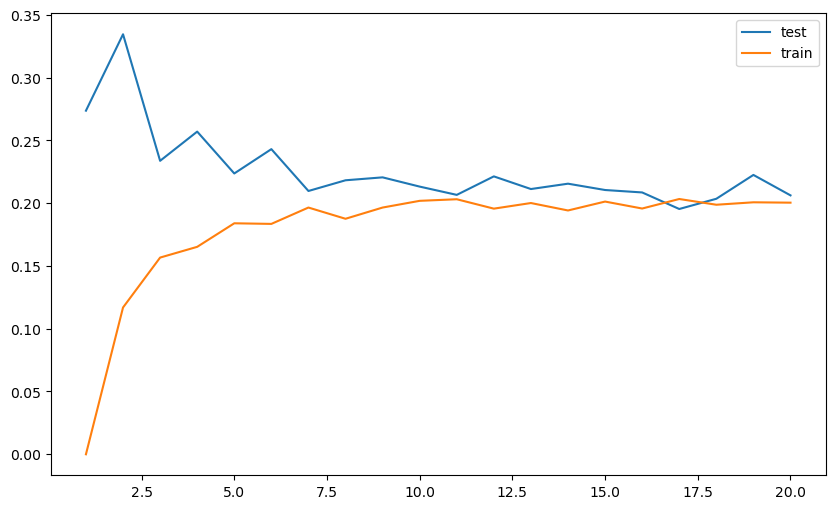

In [53]:
# Extracting the train and the test error for each k in a list for easy plotting

kltest = []
vltest = []
for k, v in knn_many_split.items():
    kltest.append(k)
    vltest.append(knn_many_split[k][1])

kltrain = []
vltrain = []

for k, v in knn_many_split.items():
    kltrain.append(k)
    vltrain.append(knn_many_split[k][0])

# Plotting k vs error 
plt.figure(figsize=(10,6))
plt.plot(kltest,vltest, label = 'test' )
plt.plot(kltrain,vltrain, label = 'train')
plt.legend()
plt.show()

- We can see that the train error and the test error are more or less similar for K more than or equal to 7.
- This implies that we would get generalized results if we choose K=7.
- So, let's scale the full data and fit the model on the entire training set. 

In [54]:
# scaling the data
scaler=StandardScaler()
X_train_scaled=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)  #fit_transform the training data
X_test_scaled=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns) #transform the testing data

In [55]:
#Fitting the model on the scaled data
knn = KNeighborsClassifier(n_neighbors = 7, weights='distance')
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

**Now, let's check the performance of the model on the training and testing data**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       131
           1       1.00      1.00      1.00       298

    accuracy                           1.00       429
   macro avg       1.00      1.00      1.00       429
weighted avg       1.00      1.00      1.00       429



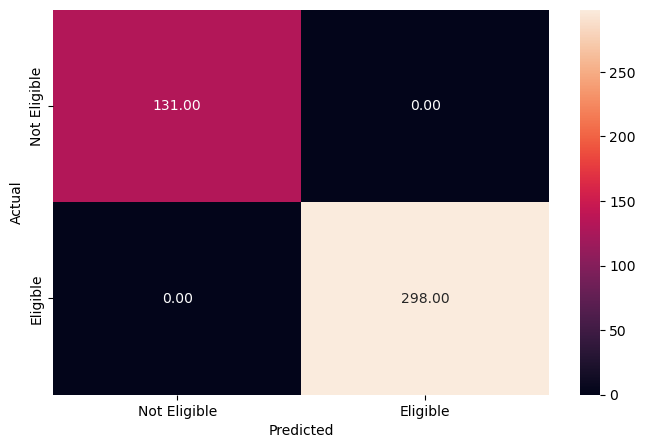

In [56]:
#predicting on train data
y_pred_train_knn = knn.predict(X_train_scaled)# write your code here

#checking performance of the model
metrics_score(y_train, y_pred_train_knn)

* The performance on the training set is very strong, as it predicts perfectly who is eligible and who isn't. The precission, recall, and and accuracy are all optimal at 100%. 

              precision    recall  f1-score   support

           0       0.61      0.31      0.41        61
           1       0.73      0.90      0.81       124

    accuracy                           0.71       185
   macro avg       0.67      0.61      0.61       185
weighted avg       0.69      0.71      0.68       185



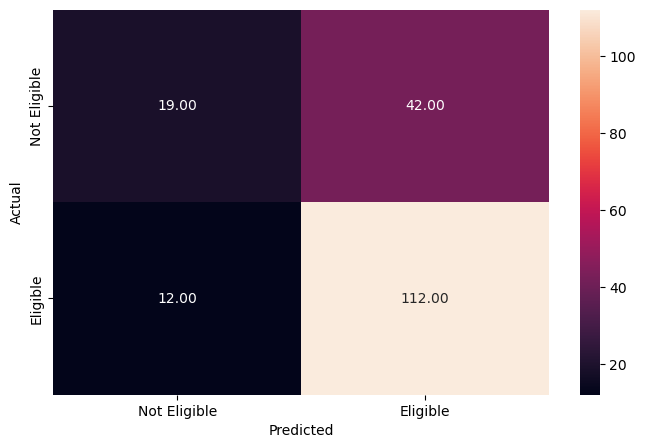

In [58]:
#predict on test data
y_pred_test_knn = knn.predict(X_test_scaled)

#checking performance of the model
metrics_score(y_test, y_pred_test_knn)

* We see a weak performance on the scaled testing data, as the recall score is only 0.31 for the 0. There were 42 people that our Knn model predicted to be eligible who are actually not eligible, which is concerning given that we want to minimize this value as much as possible. 

## Conclusion

* Through the use of multiple models, EDA, and visualization, we identified the key factor affecting loan application acceptance: credit history.

* We aimed to maximize the recall score in our Logistic regression model as it measures the ability to identify applicants who may default on loans. Our top priority is to avoid granting loans to applicants who cannot repay them, as this could harm the company. As a result, the Logistic regression model provided the highest recall score.